In [2]:
from loadData import ThoraxDataLoader
import SimpleITK 
import skimage.io as io

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

import numpy as np

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torch.nn.functional as F

from matplotlib import cm
from matplotlib.colors import ListedColormap

In [3]:
loader = ThoraxDataLoader("../../Data/Data_Medical/MCsimulations")
LS_dataset = loader.load_all_samples("LS")
CT_dataset = loader.load_all_samples("CT")
y_dataset = loader.load_all_samples("HS")
newcmp = loader.newcmp

sample_0087 chargé avec succès.
sample_1155 chargé avec succès.
sample_4427 chargé avec succès.
sample_1969 chargé avec succès.
sample_6370 chargé avec succès.
sample_3602 chargé avec succès.
sample_6142 chargé avec succès.
sample_3430 chargé avec succès.
sample_1367 chargé avec succès.
sample_4615 chargé avec succès.
sample_3868 chargé avec succès.
sample_6526 chargé avec succès.
sample_3054 chargé avec succès.
sample_2186 chargé avec succès.
sample_1703 chargé avec succès.
sample_4271 chargé avec succès.
sample_1531 chargé avec succès.
sample_5191 chargé avec succès.
sample_4043 chargé avec succès.
sample_3266 chargé avec succès.
sample_2172 chargé avec succès.
sample_0625 chargé avec succès.
sample_5357 chargé avec succès.
sample_4285 chargé avec succès.
sample_5959 chargé avec succès.
sample_0417 chargé avec succès.
sample_5165 chargé avec succès.
sample_3292 chargé avec succès.
sample_2340 chargé avec succès.
sample_0073 chargé avec succès.
sample_5501 chargé avec succès.
sample_6

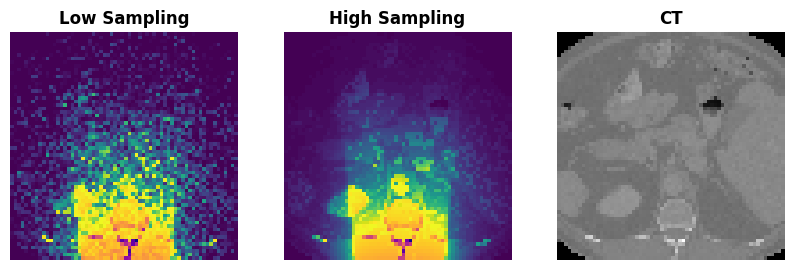

In [4]:
train_lenght = int(0.70*len(LS_dataset))
val_lenght = int(0.80*len(LS_dataset))

LS = LS_dataset[val_lenght,:,:]
CT = CT_dataset[val_lenght,:,:]
HS = y_dataset[val_lenght,:,:]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(LS, interpolation=None, cmap=newcmp)
axes[0].set_title('Low Sampling', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(HS, interpolation=None, cmap=newcmp)
axes[1].set_title('High Sampling', fontweight='bold')
axes[1].axis('off')

axes[2].imshow(CT, interpolation=None, cmap='gray')
axes[2].set_title('CT', fontweight='bold')
axes[2].axis('off')

plt.show()

In [5]:
import os
import segmentation_models_pytorch as smp
import torch

/Users/samirabinovitch/Documents/CentraleSupelec 2A/Pôle Projet Radiothérapie/projet_S7_radio/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
current_dir = os.getcwd()

target_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..', '..', "unet-with-transform",))
print(target_dir)

# Charger le modèle pré-entraîné
model = smp.from_pretrained(target_dir)

os.chdir(current_dir)

# Modifier les paramètres pour accepter 2 canaux en entrée
model_init_params = {
    "encoder_name": "resnet34",
    "encoder_depth": 5,
    "encoder_weights": "imagenet",
    "decoder_use_batchnorm": True,
    "decoder_channels": (256, 128, 64, 32, 16),
    "decoder_attention_type": None,
    "in_channels": 2,  # Modifier pour 2 canaux en entrée
    "classes": 1,       # Une seule image en sortie
    "activation": None,
    "aux_params": None
}


/Users/samirabinovitch/Documents/CentraleSupelec 2A/unet-with-transform
Loading weights from local directory


In [7]:
# Reconstruire le modèle avec les nouveaux paramètres
model = smp.Unet(**model_init_params)

# Vérifier la taille de sortie
test_input = torch.randn(1, 2, 64, 64)  # Batch de 1, 2 canaux, 64x64
output = model(test_input)
print(output.shape)  # Devrait être [1, 1, 64, 64]



torch.Size([1, 1, 64, 64])


In [9]:
for param in model.encoder.parameters():
    param.requires_grad = False  # Geler l'encodeur


In [10]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.L1Loss()  # L1 pour la reconstruction
optimizer = optim.Adam(model.decoder.parameters(), lr=1e-4)  # On entraîne uniquement le décodeur

# Pour entraîner aussi l'encodeur, décommenter la ligne suivante
#optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [11]:
train_lenght = int(0.70*len(LS_dataset))
val_lenght = int(0.80*len(LS_dataset))

LS_train = torch.tensor(LS_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
CT_train = torch.tensor(CT_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
x_train = torch.cat((LS_train, CT_train), dim=1)
y_train = torch.tensor(y_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)

LS_val = torch.tensor(LS_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
CT_val = torch.tensor(CT_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
x_val = torch.cat((LS_val, CT_val), dim=1)
y_val = torch.tensor(y_dataset[train_lenght:val_lenght,:,:],  dtype=torch.float32).unsqueeze(1)

LS_test = torch.tensor(LS_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
CT_test = torch.tensor(CT_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
x_test = torch.cat((LS_test, CT_test), dim=1)
y_test = torch.tensor(y_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

(torch.Size([4592, 2, 64, 64]),
 torch.Size([4592, 1, 64, 64]),
 torch.Size([656, 2, 64, 64]),
 torch.Size([656, 1, 64, 64]),
 torch.Size([1312, 2, 64, 64]),
 torch.Size([1312, 1, 64, 64]))

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

batch_size = 10
num_epochs = 200  # Augmentez si nécessaire

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Initialiser les gradients

            outputs = model(inputs)  # Passage dans le modèle
            loss = criterion(outputs, targets)  # Calcul de la perte

            loss.backward()  # Rétropropagation
            optimizer.step()  # Mise à jour des poids

            running_loss += loss.item()
            if (i + 1) % 115 == 0:  # Affichage toutes les 115 itérations
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss:.4f}")

        evaluate_model(model, val_loader, criterion, device)  # Évaluation sur validation

# Fonction d'évaluation
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

# Lancer l'entraînement
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

# Sauvegarde du modèle
torch.save(model.state_dict(), "UNet_finetuned.pth")
print("Entraînement terminé et modèle sauvegardé.")

Epoch [1/200], Batch [115/460], Loss: 0.1132
Epoch [1/200], Batch [230/460], Loss: 0.0631
Epoch [1/200], Batch [345/460], Loss: 0.0312
Epoch [1/200], Batch [460/460], Loss: 0.0722
Validation Loss: 0.0465
Epoch [2/200], Batch [115/460], Loss: 0.0239
Epoch [2/200], Batch [230/460], Loss: 0.0165
Epoch [2/200], Batch [345/460], Loss: 0.0214
Epoch [2/200], Batch [460/460], Loss: 0.0527
Validation Loss: 0.0332
Epoch [3/200], Batch [115/460], Loss: 0.0178
Epoch [3/200], Batch [230/460], Loss: 0.0143
Epoch [3/200], Batch [345/460], Loss: 0.0121
Epoch [3/200], Batch [460/460], Loss: 0.0341
Validation Loss: 0.0238
Epoch [4/200], Batch [115/460], Loss: 0.0144
Epoch [4/200], Batch [230/460], Loss: 0.0116
Epoch [4/200], Batch [345/460], Loss: 0.0132
Epoch [4/200], Batch [460/460], Loss: 0.0399
Validation Loss: 0.0299
Epoch [5/200], Batch [115/460], Loss: 0.0158
Epoch [5/200], Batch [230/460], Loss: 0.0172
Epoch [5/200], Batch [345/460], Loss: 0.0126
Epoch [5/200], Batch [460/460], Loss: 0.1600
Vali

KeyboardInterrupt: 

In [33]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Met le modèle en mode évaluation (désactive le dropout, etc.)
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Pas besoin de calculer les gradients pendant l'évaluation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Passage dans le modèle
            outputs = model(inputs)
            
            # Calcul de la perte
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # Collecter les prédictions et les vraies étiquettes
            preds = outputs.argmax(dim=1)  # Utilisez `argmax` si c'est une tâche de classification multi-classe
            all_preds.extend(preds.cpu().numpy())  # Déplacer les prédictions vers le CPU et les collecter
            all_targets.extend(targets.cpu().numpy())  # Idem pour les cibles
            
    # Calcul de la perte moyenne de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

In [34]:
def calculate_psnr(original, reconstructed, data_range=1.0):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return np.inf
    psnr = 10*np.log10(data_range**2 / mse)
    return psnr

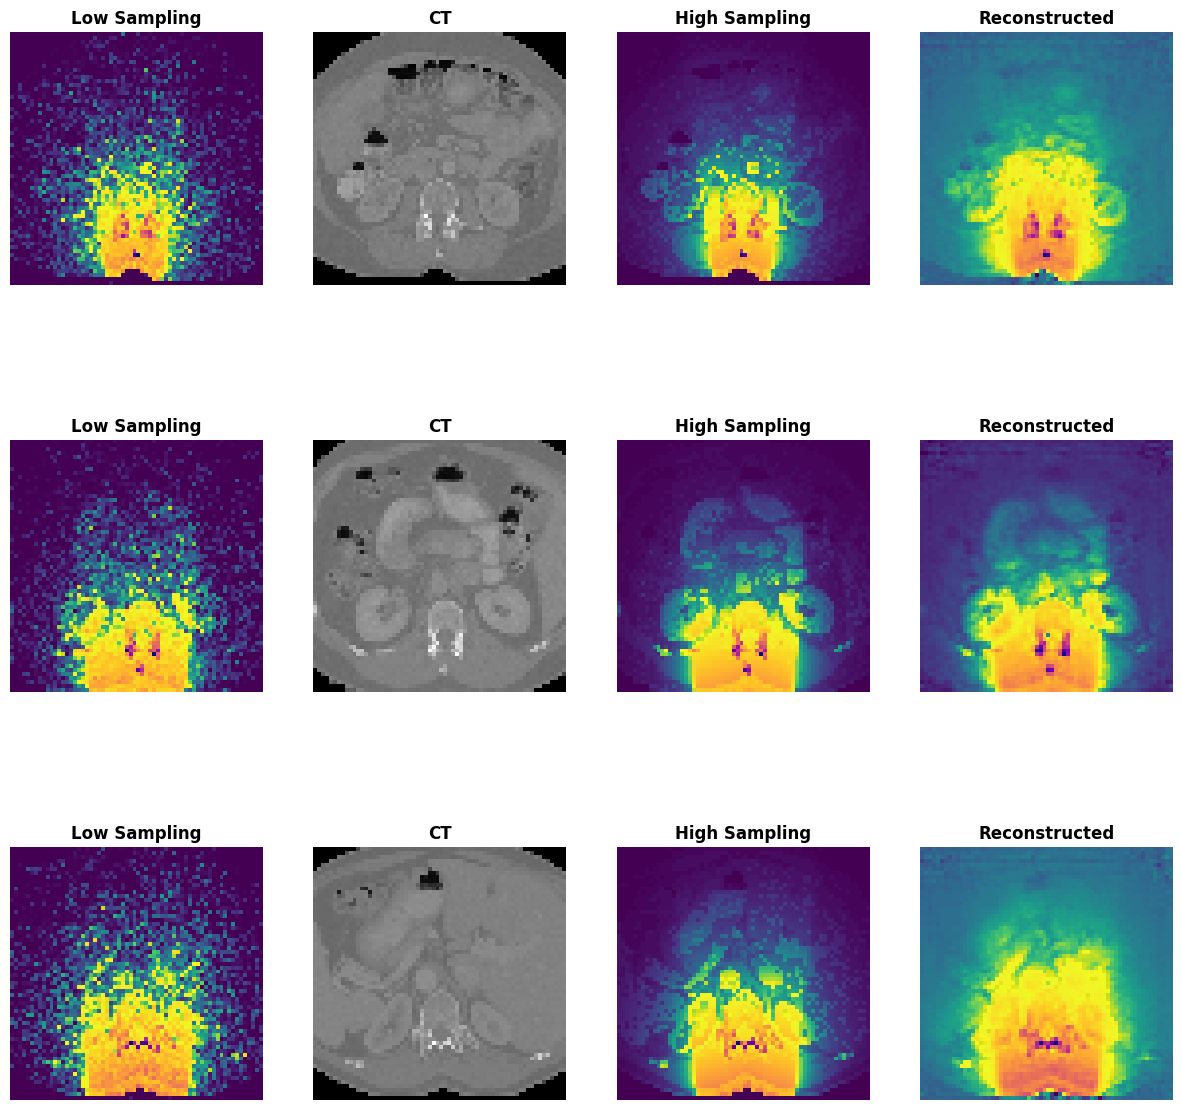

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Déplacez le modèle sur l'appareil approprié
model = model.to(device)

# Déplacez les données d'entrée sur le même appareil que le modèle
x_test = x_test.to(device)

# Effectuez la prédiction
model.eval()
with torch.no_grad():
    y_pred = model(x_test).cpu()  # Revenir sur CPU si nécessaire pour l'évaluation

y_pred2 = y_pred.cpu().squeeze(1).numpy()
y_test2 = y_test.cpu().squeeze(1).numpy()

fig, axes = plt.subplots(3, 4, figsize=(15, 15))
k = 10 # Pour visualiser d'autres exemples
for i in range(3):
    axes[i, 0].imshow(x_test[i+k, 0].cpu().numpy(), cmap=newcmp)
    axes[i, 0].set_title('Low Sampling', fontweight='bold')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(x_test[i+k, 1].cpu().numpy(), cmap='gray')
    axes[i, 1].set_title('CT', fontweight='bold')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(y_test2[i+k], cmap=newcmp)
    axes[i, 2].set_title('High Sampling', fontweight='bold')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(y_pred2[i+k], cmap=newcmp)
    axes[i, 3].set_title('Reconstructed', fontweight='bold')
    axes[i, 3].axis('off')

In [38]:
mean_psnr = np.mean([calculate_psnr(y_test2[i], y_pred2[i]) for i in range(len(y_test2))])
print(f"Mean PSNR: {mean_psnr:.2f} dB")

Mean PSNR: 34.40 dB
